# Setup environment

In [1]:
!pip install gensim emoji nltk tqdm seaborn torch torchsummary -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 28.7 MB/s eta 0:00:00


In [2]:
!pip install torch

In [3]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

import gensim

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import gc
import os

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# Config

## Model training config

In [4]:
LEARNING_RATE = 4e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
EPOCHS = 15

SEQUENCE_LEN = 64
CNN_FILTERS = 64

In [5]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Preparation, section 0

<font color='red'>1.</font>
Consistency: Lowercasing text ensures consistency in the dataset, making it easier to manage and process. This is particularly beneficial when dealing with large datasets where manual correction of inconsistent capitalizations would be impractical 2.

Simplification: It simplifies the text by eliminating the distinction between uppercase and lowercase letters, which can be helpful in reducing noise and focusing on the semantic content of the text 2.

Loss of Meaning: In some contexts, capitalization can carry significant meaning. For example, proper nouns and acronyms lose their identity when converted to lowercase. This can lead to inaccuracies in tasks where preserving the original meaning is crucial 4.

Overly Simplistic Approach: While lowercasing is a straightforward approach, it might not be suitable for all NLP tasks. More nuanced approaches, such as preserving capitalization in certain contexts or using lemmatization/stemming techniques, might offer better results in specific scenarios

Text preprocessing, including lowercasing, is essential for preparing textual data for analysis and modeling in NLP. Unstructured or unusually formatted text can introduce noise and ambiguity, complicating the training of machine learning models.


<font color='red'>2.</font>
Reducing Noise: Sometimes, numbers in text do not carry meaningful information relevant to the task at hand. Removing them can help reduce noise and focus on the textual content 23.

Standardization: Uniformity in text data is crucial for effective processing. Removing numbers can standardize the text, making it easier to tokenize and analyze

Impact on Specific Tasks: For tasks like Named Entity Recognition (NER) or Part of Speech (POS) tagging, numbers play a significant role. Removing numbers might negatively impact the performance of models trained for these tasks 2.

Generalization Limitations: Some algorithms and models might benefit from the inclusion of numbers in the text, especially those that leverage statistical properties of the data. Completely removing numbers could limit the effectiveness of these models 3.

<font color='red'>3.</font>
Contextual Significance: Hashtags can carry significant contextual information, especially in social media data. They can indicate topics, trends, or categories that the text belongs to. Keeping hashtags can enrich the model's understanding of the text's context 2.

Feature Extraction: Hashtags can serve as unique identifiers or markers for specific themes or events. Including hashtags in the preprocessing pipeline can allow models to recognize and utilize these thematic markers, potentially enhancing the model's performance on tasks that benefit from such contextual cues 2.

## Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd

file_path = '/content/drive/My Drive/twitter-suicidal-data.csv'
df = pd.read_csv(file_path)

## Data Preprocessing

In [8]:
import nltk
import emoji
import re

nltk.download(["stopwords", "punkt", "wordnet", "averaged_perceptron_tagger"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [9]:
def convert_emoji_to_text(text):
    # removing wierd patterns
    wierd_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u'\U00010000-\U0010ffff'
        u"\u200d"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\u3030"
        u"\ufe0f"
        u"\u2069"
        u"\u2066"
        u"\u2068"
        u"\u2067"
        "]+", flags=re.UNICODE)

    text = wierd_pattern.sub(r' ', text)
    return text

stopwords = nltk.corpus.stopwords.words("english")
lemmatizer = nltk.stem.WordNetLemmatizer()

def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return 'a'
    elif nltk_tag.startswith('V'):
        return 'v'
    elif nltk_tag.startswith('N'):
        return 'n'
    elif nltk_tag.startswith('R'):
        return 'r'
    else:
        return 'n'

def preprocess_data(text: str):
    """
    Preprocessing steps are as follows:
    1. lowercase the text
    2. remove punctuation
    3. remove numbers
    4. remove urls
    5. remove usernames
    6. remove extra spaces
    7. convert emojis to text
    8. remove non-word characters
    9. lemmatization and tokenization of the text
    10. remove stopwords
    :param text: str
    :return: tokens: list[str]
    """

    # lowercase the text
    text = text.lower()

    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # remove numbers
    text = re.sub(r'\d+', '', text)

    # remove urls
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # remove usernames
    text = re.sub(r'@\w+', '', text)

    # remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # convert emojis to text
    text = convert_emoji_to_text(text)

    # remove non-word characters
    text = re.sub(r'\W+', ' ', text)

    # tokenization
    tokens = nltk.word_tokenize(text)

    # lemmatization
    tokens = [lemmatizer.lemmatize(token, nltk_pos_tagger(tag)) for token, tag in nltk.pos_tag(tokens)]

    # remove stopwords
    tokens = [token for token in tokens if token not in stopwords]

    return tokens


<font color='red'>4.</font>

In [10]:
# Select a subset of the data for demonstration
sample_texts = df['tweet'].head(5)  # Assuming the text column is named 'text'

# Show samples before preprocessing
print("Samples before preprocessing:")
for i, text in enumerate(sample_texts):
    print(f"Sample {i+1}: {text}")

# Apply preprocessing
preprocessed_texts = sample_texts.apply(lambda x: preprocess_data(str(x)))

# Show samples after preprocessing
print("\nSamples after preprocessing:")
for i, tokens in enumerate(preprocessed_texts):
    print(f"Sample {i+1}: {' '.join(tokens)}")


Samples before preprocessing:
Sample 1: my life is meaningless i just want to end my life so badly my life is completely empty and i dont want to have to create meaning in it creating meaning is pain how long will i hold back the urge to run my car head first into the next person coming the opposite way when will i stop feeling jealous of tragic characters like gomer pile for the swift end they were able to bring to their lives
Sample 2: muttering i wanna die to myself daily for a few months now i feel worthless shes my soulmate i cant live in this horrible world without her i am so lonely i wish i could just turn off the part of my brain that feels 
Sample 3: work slave i really feel like my only purpose in life is to make a higher man money parents forcing me through college and i have too much on my plate i owe a lot of money i know this is the easy way out but i am really tired all of these issues are on top of dealing with tensions in america as well i want to rest
Sample 4: i did

<font color='red'>5.</font>

   intention  min   max       mean
0          0    0    38   8.968366
1          1    1  2142  73.646573


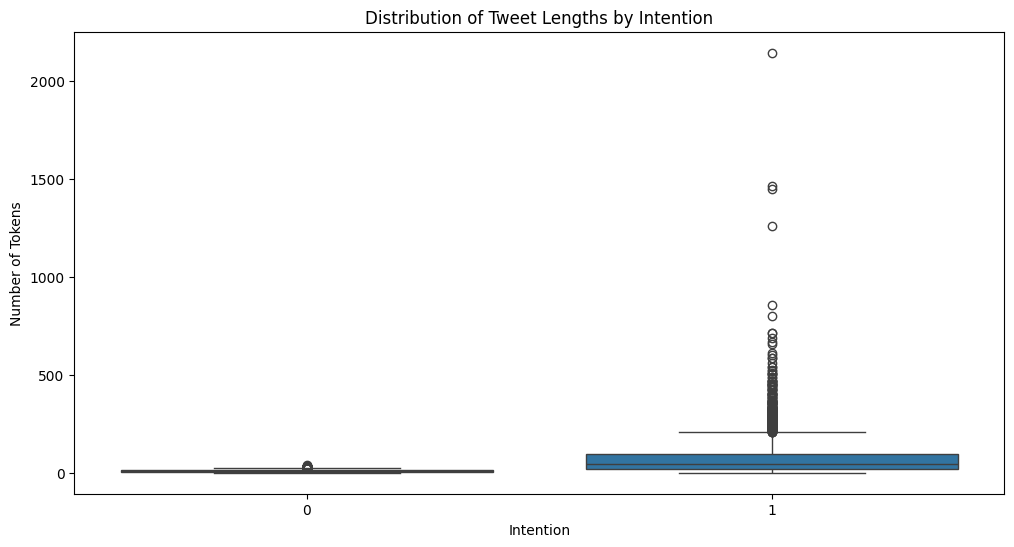

In [64]:
## Apply preprocessing
df['preprocessed_tweet'] = df['tweet'].apply(lambda x: preprocess_data(str(x)))

# Calculate token sizes
df['token_size'] = df['preprocessed_tweet'].apply(len)

# Group by 'intention' and calculate min, max, and average token sizes
stats = df.groupby('intention')['token_size'].agg(['min', 'max', 'mean']).reset_index()

# Display the stats
print(stats)

# Plot the distribution using a box plot for visualization
plt.figure(figsize=(12, 6))
sns.boxplot(x='intention', y='token_size', data=df)
plt.title('Distribution of Tweet Lengths by Intention')
plt.xlabel('Intention')
plt.ylabel('Number of Tokens')
plt.show()

In [65]:

# Find the tweet with the maximum number of tokens
max_token_tweet = df.loc[df['token_size'].idxmax()]

print("\nTweet with the maximum number of tokens:")
print(f"Original tweet: {max_token_tweet['tweet']}")
print(f"Preprocessed tweet: {' '.join(max_token_tweet['preprocessed_tweet'])}")
print(f"Number of tokens: {max_token_tweet['token_size']}")


Tweet with the maximum number of tokens:
Original tweet: my diary log as of so far okay my first time writing this i know i will sound like some emo whiny attention whore bitch but i need to talk about this personally since nobody really cares or can really help or really gives to fucks or stereotypes mefirst off i wish i could stop looking down on myself i can t do it because i m always left behind i can t stand to see others treat me different i m treated as if i m not like everyone else and it s been like that since i was young and it reminds me of those times making me feel empty and unwanted i ve tried so hard to grow up with at least a good image on myself yet i still can not grow to find my own meaning i try to make others laugh it s my root of my own happiness i try so hard to bring you and others joy yet the flame slowly dies and i can feel it but i hold on because i feel something special something wanted i feel like as if we need eachother as if we are meant to be and i m s

# Word2Vec - Word Embedding section 1

<font color='red'>1.</font>

Initializing with Zero Vector

Pros

Simplicity: Using a zero vector for unknown words is straightforward and computationally inexpensive. It does not require additional resources or complex preprocessing steps 1.

Uniformity: This approach ensures that all embeddings have the same initial state, which can be beneficial for training models, especially when the model learns to differentiate between known and unknown words during training 1.

Flexibility: It provides flexibility in handling OOV words by allowing the model to learn from the context in which these words appear. This can sometimes lead to reasonable approximations of the meanings of unknown words 1.

Cons

Lack of Semantic Information: A zero vector carries no semantic information about the word, which can be limiting, especially for tasks where capturing the nuances of word meanings is crucial 1.
Potential for Dilution: Using a uniform zero vector for all unknown words can dilute the learning signal, making it harder for the model to distinguish between different types of unknown words based on their context 1.

Dependency on Context: The success of this approach heavily relies on the model's ability to infer the meaning of unknown words from their context. This might not always be reliable, especially in cases where the context does not provide enough clues 1.

Learning to Predict Embeddings:

Train a model to predict the embedding of an unknown word based on its context. This approach can dynamically adapt to unseen words but requires additional training data.

Pros: Adapts to the specific domain and context.

Cons: Increases model complexity and training time.

In [11]:
# print available word2vec models
import gensim.downloader as api
print("\n".join(api.info()['models'].keys()))

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [12]:
# Define the path to save the Word2Vec model
W2V_PATH = '/content/drive/MyDrive/word2vec-google-news-300/word2vec-google-news-300.model'

if W2V_PATH is not None and os.path.exists(W2V_PATH):
    print("Loading Word2Vec model...")
    w2v_model = gensim.models.KeyedVectors.load(W2V_PATH, mmap='r')
    print("Word2Vec model is loaded.")
else:
    print("Downloading Word2Vec model...")
    w2v_model = api.load("word2vec-google-news-300")
    print("Word2vec model is downloaded.")
    if W2V_PATH is not None:
      print("\nSaving Word2Vec model...")
      w2v_model.save(W2V_PATH)
      print("Word2Vec model is saved.")

Loading Word2Vec model...
Word2Vec model is loaded.


In [13]:
EMBEDDING_VECTOR_DIM = w2v_model.vector_size
print(EMBEDDING_VECTOR_DIM)

300


# Dataset

In [14]:
class Twitter(Dataset):
    def __init__(self, dataframe: pd.DataFrame, w2v_model: gensim.models.KeyedVectors, sequence_len: int):
        self.dataframe = dataframe
        self.w2v_model = w2v_model
        self.max_sequence_len = sequence_len
        self.vector_size = w2v_model.vector_size

        self.df_token_col = "tokens"


        self._proc_dataset()

        self.len = len(self.dataframe)

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.dataframe.iloc[idx]["vector"], self.dataframe.iloc[idx]["intention"]

    def get_vector_size(self):
        return self.vector_size

    def _proc_dataset(self):
        # Preprocess and return tokens list
        self.dataframe[self.df_token_col] = self.dataframe["tweet"].map(preprocess_data)

        # delete samples with empty tokens
        lwz = len(self.dataframe)
        self.dataframe = self.dataframe[self.dataframe[self.df_token_col].map(len) > 0]
        self.dataframe.reset_index(drop=True, inplace=True)
        print(f"Deleted 0-Len Samples: {lwz - len(self.dataframe)}")

        # Add padding
        self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)

        # Get embedding's vectors
        self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)

    def _get_word_vectors(self, tokens: list) -> torch.tensor:

      vectors = []
      for token in tokens:
          if token in self.w2v_model:
              vectors.append(self.w2v_model[token])
          else:
              vectors.append(np.zeros(self.vector_size))
      return self._to_tensor(vectors)

    def _pad(self, tokens: list):

        if len(tokens) < self.max_sequence_len:
            tokens.extend(['<PAD>'] * (self.max_sequence_len - len(tokens)))
        else:
            tokens = tokens[:self.max_sequence_len]
        return tokens

    def seq_report(self):
        length_all = self.dataframe[self.df_token_col].map(len).tolist()
        max_length = np.max(length_all)
        print(f"Sequence Length Report")
        print(f":::::MAX  LENGTH:::[{max_length:^5}]")
        print(f":::::MIN  LENGTH:::[{np.min(length_all):^5}]")
        print(f":::::MEAN LENGTH:::[{np.mean(length_all):^5}]")

        all_tokens = set()
        for token_set in self.dataframe[self.df_token_col].tolist():
            all_tokens = all_tokens.union(set(token_set))
        unique_tokens_count = len(all_tokens)
        valid_tokens = sum(1 if token in self.w2v_model else 0 for token in all_tokens)
        print("Sequence Tokenization Report")
        print(f":::::All Unique Tokens:::[{unique_tokens_count:^6}")
        print(f":::::All Valid Tokens:::[{valid_tokens:^6}")
        print(f":::::Valid Tokens:::[{round(100*valid_tokens/unique_tokens_count, 2):^5}%]")

    @staticmethod
    def _to_tensor(tokens: list):
        return torch.tensor(tokens, dtype=torch.float32)

In [15]:
sequence_len = 64

# Initialize the Twitter dataset
dataset = Twitter(df, w2v_model, sequence_len)
dataset.seq_report()

Deleted 0-Len Samples: 31


<ipython-input-14-3c869faa1126>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-14-3c869faa1126>:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(tokens, dtype=torch.float32)
<ipython-input-14-3c869faa1126>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Sequence Length Report
:::::MAX  LENGTH:::[ 64  ]
:::::MIN  LENGTH:::[ 64  ]
:::::MEAN LENGTH:::[64.0 ]
Sequence Tokenization Report
:::::All Unique Tokens:::[15874 
:::::All Valid Tokens:::[10646 
:::::Valid Tokens:::[67.07%]


In [16]:
# Example of fetching data
for i in range(len(dataset)):
    vector, intention = dataset[i]
    print(f"Vector shape: {vector.shape}, Intention: {intention}")
    print(vector)
    break

Vector shape: torch.Size([64, 300]), Intention: 1
tensor([[-0.0679,  0.0952,  0.0356,  ...,  0.1270, -0.1035,  0.0476],
        [ 0.2578,  0.0258,  0.2168,  ...,  0.0649, -0.1816,  0.0520],
        [ 0.1367,  0.1484,  0.1147,  ..., -0.1826,  0.0444, -0.0417],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


# Prepare Data

## Split Data into train-valid

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming `dataset` is a list of (vector, intention) tuples
# Example: dataset = [(np.array([0.1, 0.2, 0.3]), 'intention1'), (np.array([0.4, 0.5, 0.6]), 'intention2'), ...]

# Extract features and labels
vectors = [item[0] for item in dataset]
intentions = [item[1] for item in dataset]

# Convert lists to numpy arrays
vectors = np.array(vectors)
intentions = np.array(intentions)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vectors, intentions, test_size=0.2, random_state=42)


In [18]:
X_train_reshaped = X_train.transpose(0, 2, 1)  # Permute the dimensions
X_test_reshaped = X_test.transpose(0, 2, 1)  # Permute the dimensions
print(X_train_reshaped.shape)


(7270, 300, 64)


## Create Datasets

In [ ]:
print(X_train.shape)
print(X_train_reshaped.shape)


(7270, 64, 300)
(7270, 300, 64)


# Model and Train section 2

<font color='red'>1.</font>

SGD

Basic Form of Gradient Descent: SGD is the simplest form of gradient descent, where the batch size is 1. It updates the model parameters by subtracting the gradient multiplied by the learning rate from the current parameter values 2.

Adam

Adaptive Learning Rates: Adam adapts the learning rates for each weight individually, based on the average of the second moments (uncentered variance) of the gradients. This makes it more robust to noisy gradients and can accelerate convergence 3.

Key Differences

Complexity vs. Simplicity: Adam introduces additional complexity with its adaptive learning rates, whereas SGD operates with a constant learning rate, making it simpler to understand and implement

<font color='red'>2.</font>

Advantages of Using Cross-Entropy for Binary Classification in NLP

Probabilistic Interpretation:

Cross-entropy inherently deals with probabilities, making it suitable for tasks where the output is a probability distribution over classes. This is ideal for binary classification, where the model predicts the probability of belonging to one class versus another 1.

Handling Imbalanced Datasets:

Binary cross-entropy is effective in handling imbalanced datasets by assigning higher penalties for misclassifying the minority class. This is particularly useful in NLP tasks where the classes might not be evenly distributed 1.

<font color='red'>3.</font>

test_size=0.2

Balance Between Training and Testing:

 A test_size of 0.2 means that 20% of the dataset is reserved for testing, leaving 80% for training. This allocation is considered a good starting point for many projects, providing a sufficient amount of data for training while still having a substantial portion for testing


<font color='red'>4.</font>

Large Kernel Sizes (e.g., 7x7, 11x11):

Broad Patterns: Larger kernels capture broader patterns and more contextual information within a single layer. This is useful for identifying large structures or objects in the input data.

Fewer Layers: Networks with larger kernels can potentially use fewer layers to capture the same level of global context. This can make the network shallower, reducing the depth and potentially the computational cost associated with deep networks.

Small Kernel Sizes (e.g., 3x3, 5x5):

Fine Details: Smaller kernels capture fine details and small features in the input data. This is particularly useful for tasks requiring high precision and detail, such as edge detection and texture analysis.

More Layers: To capture larger patterns, a network with small kernels requires more layers, which allows for deeper hierarchical feature extraction. Each subsequent layer can combine features from previous layers to detect more complex patterns.



<font color='red'>5.</font>

Convolutional Layers:

Convolutional layers are primarily designed to preserve and leverage the spatial relationships within the data. They apply local filters to detect local patterns and features across the spatial dimensions of the input.

When used to reduce dimensions, convolutional layers would still focus on local patterns, which might not effectively combine global information from the entire feature map.

Linear Layers:

Linear layers (fully connected layers) treat the input as a single-dimensional vector and combine information from all spatial locations. This allows them to aggregate global features from the entire feature map.

They are effective at summarizing the extracted features into a fixed-size vector, which is essential for tasks like classification where each class needs to be represented by a unique set of features.

## Utils

In [19]:
pip install typing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 874.7 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=496d5a2d9daf42ddc1853e1c1553697e64df4c75dbeab24e2fee30796e9c34b6
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


In [20]:
from typing import Literal


@torch.no_grad()

def model_eval(model, loader, loss_function, device: Literal['cuda', 'cpu', 'auto']):
    """Returns test_loss, test_acc"""
    test_loss = 0.0
    test_acc = 0.0
    correct = 0
    total = 0
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    itr = tqdm(loader, total=len(loader), leave=False)

    for inputs, labels in itr:
        # Move model's inputs and labels to `device`
        inputs, labels = inputs.to(device), labels.to(device)

        # Use model's forward pass to generate outputs
        outputs = model(inputs)
        # print(outputs)
        # Calculate model's loss
        loss = loss_function(outputs, labels)
        test_loss += loss.item()

        # Calculate/update model's accuracy
        test_acc += (torch.argmax(outputs, 1) == labels.data).float().sum()
        total += len(labels.data)

        itr.set_description("(Eval)")
        itr.set_postfix(
            loss=round(loss.item(), 5),
            accuracy=round(test_acc.item(), 5),
        )
    test_acc /= total
    print("model val accuracy %.2f%%  Loss: %.2f" % (test_acc.cpu()*100,test_loss))
    return test_loss, test_acc


In [21]:
def train_model(
        model,
        batch_size,
        loss_function,
        optimizer,
        epochs,
        train_set,
        valid_set,
        device: Literal['cuda', 'cpu', 'auto'],
):
    # print("hi")
    if device == "auto":
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    train_losses = []
    train_accs = []

    valid_losses = []
    valid_accs = []
    # print("how")
    # TODO: create dataloaders from datasets
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

    model.to(device)
    # print("are")
    itr = tqdm(train_loader, total=len(train_loader), leave=False)

    for epoch in range(epochs):
        # print(epoch)
        err =0
        acc = 0
        c = 0
        count = 0

        for idx, (inputs, labels) in enumerate(itr, start=1):

            inputs, labels = inputs.to(device), labels.to(device)
            model.train()
            outputs = model(inputs)
            # print("the")
            # Calculate model's loss and update epoch's loss

            loss = loss_function(outputs, labels)
            optimizer.zero_grad()
            loss.backward()  # Backward calculated loss
            optimizer.step()  # Step optimizer

            acc += (torch.argmax(outputs, 1) == labels.data).float().sum()
            count += len(labels.data)
            c+=1
            err+= loss.cpu()



        acc /= count
        loss /= c

        # itr.set_description(f"(Training) Epoch [{epoch + 1}/{epochs}]")
        # itr.set_postfix(
        #   loss=round(loss.item(), 5),
        #   accuracy=round(acc, 5),
        #   )
        print(f"Epoch %d: model train accuracy %.2f%% Loss: %.2f" % (epoch, acc.cpu()*100,loss.cpu()))


        model.eval()
        valid_loss, valid_acc = model_eval(
            model=model,
            loader=valid_loader,
            loss_function=loss_function,
            device=device
            )

        # TODO: update statistics regaurding model's loss and acc in training or validation phases
        train_losses.append(loss)
        train_accs.append(acc)
        valid_losses.append(valid_loss)
        valid_accs.append(valid_acc)
    history = {
      "train_loss": train_losses,
      "train_acc": train_accs,

      "valid_loss": valid_losses,
      "valid_acc": valid_accs,
    }
    return history

In [22]:
def trend_plot_helper(pobj):
    plt.figure(figsize=(5*len(pobj), 5))
    for idx, (titler, plots) in enumerate(pobj.items(), start=1):
        plt.subplot(1, len(pobj), idx)
        for label, trend in plots:
            plt.plot(range(1, len(trend)+1), trend, label=label)
        yt, xt = titler.split(' - ')
        plt.xlabel(xt)
        plt.ylabel(yt)
        plt.legend()




In [23]:
@torch.no_grad()
def generate_confusion_matrix(model, dataset, device='auto'):
    if device == 'auto':
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    itr = tqdm(loader, leave=False, desc="Generate data")

    # TODO: code here, you must fill variables below
    all_labels = []
    all_predicted = []

    for inputs, labels in itr:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predicted.extend(predicted.cpu().numpy())

    labels = all_labels
    predicted = all_predicted

    cm = metrics.confusion_matrix(
        y_true=labels,
        y_pred=predicted,
    )

    plt.figure(figsize=(10,10))
    sns.heatmap(cm, cmap='Blues', annot=True, cbar=False, fmt=".0f",)
    plt.xlabel('Predicted Label', labelpad=20)
    plt.ylabel('True Label', labelpad=20)
    plt.title('Confusion Matrix', fontsize=30)

    recall = metrics.recall_score(y_true=labels, y_pred=predicted, average='macro')
    f1 = metrics.f1_score(y_true=labels, y_pred=predicted, average='macro')
    precision = metrics.precision_score(y_true=labels, y_pred=predicted, average='macro')
    report = metrics.classification_report(y_true=labels, y_pred=predicted)

    return {'recall': recall, 'f1': f1, 'precision': precision, 'report': report}


## Model's Network

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN, self).__init__()
        # print("hey")
        self.layers = nn.Sequential(*[
        nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7),
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        ])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5120, 128)  # Output size after conv1d layer
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):

        for layer in self.layers:
          x = layer(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # Softmax for classification
        return x





## Training

In [25]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets
train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)




In [ ]:
print(X_train_tensor.shape)

torch.Size([7270, 300, 64])


In [ ]:
print(train_set[0][0].shape)

torch.Size([300, 64])


# Train with 32 batch size and 0.001 lr

In [ ]:
model = CNN()
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Call the train_model function
history1 = train_model(
    model=model,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=5,
    train_set=train_set,
    valid_set=test_set,
    device='auto'  # Automatically select 'cuda' if available, otherwise 'cpu'
)



Epoch 0: model train accuracy 79.50% Loss: 0.00


model val accuracy 83.94%  Loss: 27.00
Epoch 1: model train accuracy 82.24% Loss: 0.00


model val accuracy 81.08%  Loss: 28.64
Epoch 2: model train accuracy 79.97% Loss: 0.00


model val accuracy 80.53%  Loss: 28.96
Epoch 3: model train accuracy 79.99% Loss: 0.00


model val accuracy 80.53%  Loss: 28.96
Epoch 4: model train accuracy 79.99% Loss: 0.00


model val accuracy 80.53%  Loss: 28.96


#Train with 8 batch size and 0.00001 lr

Here as we were regularly stuck in local optimum, we changed the model to have glorot initialization for each layer. The reason why we decreased learning rate that much(from 0.001 to 0.00001) lies behind the fact that in the first epoch when the weights were initilizied the model performed well but after the first epoch the model performed poorly just beacuse the high learning rate made the model to jump out of the optimum solution. In other words, it made the model get stuck in a near local optimum.

In [32]:
class CNN_glorot(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN_glorot, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
            nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5),
            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        )
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5120, 128)  # Output size after conv1d layer
        self.fc2 = nn.Linear(128, 2)

        # Apply Glorot initialization
        self._initialize_weights()

    def _initialize_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Conv1d):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # Softmax for classification
        return x

In [34]:
model3 = CNN_glorot()
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.00001)

# Call the train_model function
history3 = train_model(
    model=model3,
    batch_size=8,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=5,
    train_set=train_set,
    valid_set=test_set,
    device='auto'  # Automatically select 'cuda' if available, otherwise 'cpu'
)


Epoch 0: model train accuracy 83.25% Loss: 0.00


model val accuracy 86.63%  Loss: 101.41
Epoch 1: model train accuracy 86.19% Loss: 0.00


model val accuracy 88.06%  Loss: 98.27
Epoch 2: model train accuracy 87.51% Loss: 0.00


model val accuracy 88.17%  Loss: 97.40
Epoch 3: model train accuracy 88.25% Loss: 0.00


model val accuracy 88.45%  Loss: 96.94
Epoch 4: model train accuracy 88.58% Loss: 0.00


model val accuracy 88.56%  Loss: 96.53


#Train with 32 batch size and 0.00001 lr

In [39]:
model4 = CNN()
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.00001)

# Call the train_model function
history4 = train_model(
    model=model4,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=5,
    train_set=train_set,
    valid_set=test_set,
    device='auto'  # Automatically select 'cuda' if available, otherwise 'cpu'
)

Epoch 0: model train accuracy 70.32% Loss: 0.00


model val accuracy 85.09%  Loss: 26.49
Epoch 1: model train accuracy 84.51% Loss: 0.00


model val accuracy 86.19%  Loss: 25.57
Epoch 2: model train accuracy 85.30% Loss: 0.00


model val accuracy 86.91%  Loss: 25.24
Epoch 3: model train accuracy 85.58% Loss: 0.00


model val accuracy 86.74%  Loss: 25.19
Epoch 4: model train accuracy 86.12% Loss: 0.00


model val accuracy 87.35%  Loss: 24.91


#Evaluation of model with 32 batch size and 0.001 lr

In [ ]:
# Print classification report for the test set
test_loader = DataLoader(test_set, batch_size=32)
test_loss, test_acc = model_eval(model, test_loader, loss_function, 'auto')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


model val accuracy 80.53%  Loss: 28.96
Test Loss: 28.961681813001633, Test Accuracy: 0.8052805066108704


[tensor(0.0028, grad_fn=<DivBackward0>), tensor(0.0014, grad_fn=<DivBackward0>), tensor(0.0028, grad_fn=<DivBackward0>), tensor(0.0021, grad_fn=<DivBackward0>), tensor(0.0014, grad_fn=<DivBackward0>)]
[0.0028359433636069298, 0.0013739545829594135, 0.0028359428979456425, 0.0021049489732831717, 0.0013739545829594135]


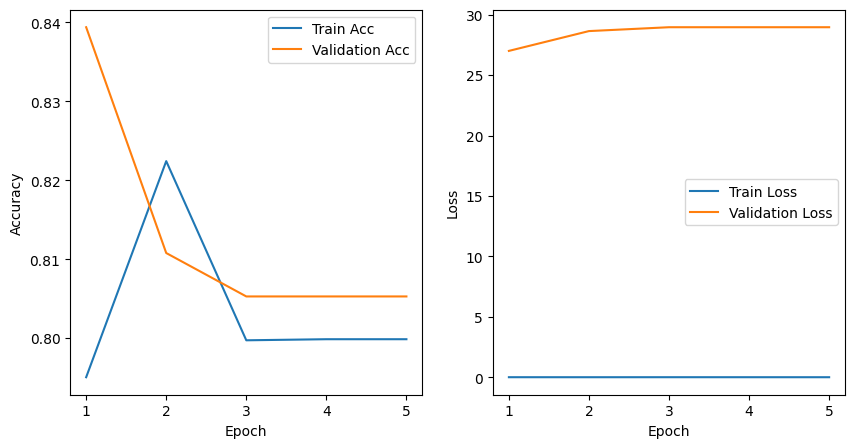

In [ ]:
print(history1["train_loss"])
train_loss = [tensor.item() for tensor in history1["train_loss"]]
print(train_loss)

trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history1["train_acc"]),
            ("Validation Acc", history1["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", train_loss),
            ("Validation Loss", history1["valid_loss"])
        ]
    }
)

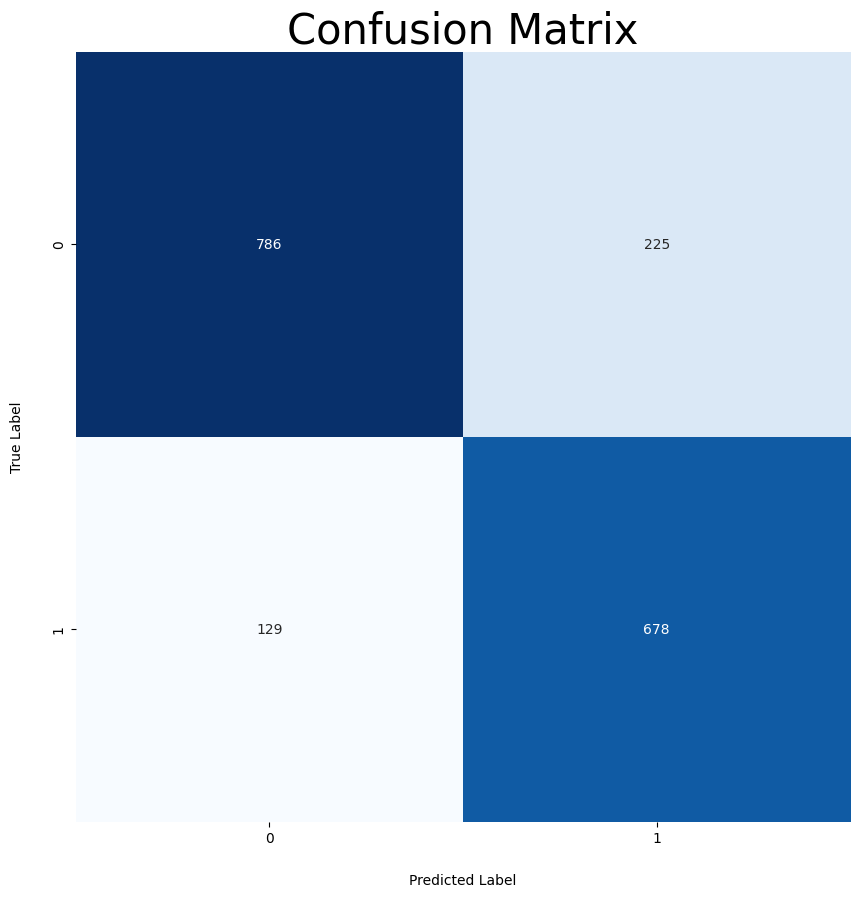

In [ ]:
cnn_model_report = generate_confusion_matrix(
    model=model,
    dataset=test_set,
)

In [ ]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.809
F1:        0.805
Precision: 0.805
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1011
           1       0.75      0.84      0.79       807

    accuracy                           0.81      1818
   macro avg       0.80      0.81      0.80      1818
weighted avg       0.81      0.81      0.81      1818



#Evaluation of model with 8 batch size and 0.00001 lr (glorot initialization)

In [35]:
# Print classification report for the test set
test_loader = DataLoader(test_set, batch_size=8)
test_loss, test_acc = model_eval(model3, test_loader, loss_function, 'auto')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")


model val accuracy 88.56%  Loss: 96.53
Test Loss: 96.52771756052971, Test Accuracy: 0.8855885863304138


[tensor(0.0006, grad_fn=<DivBackward0>), tensor(0.0005, grad_fn=<DivBackward0>), tensor(0.0005, grad_fn=<DivBackward0>), tensor(0.0004, grad_fn=<DivBackward0>), tensor(0.0005, grad_fn=<DivBackward0>)]
[0.0006311634788289666, 0.0005278204334899783, 0.0005277867312543094, 0.00037999151390977204, 0.000532846141140908]


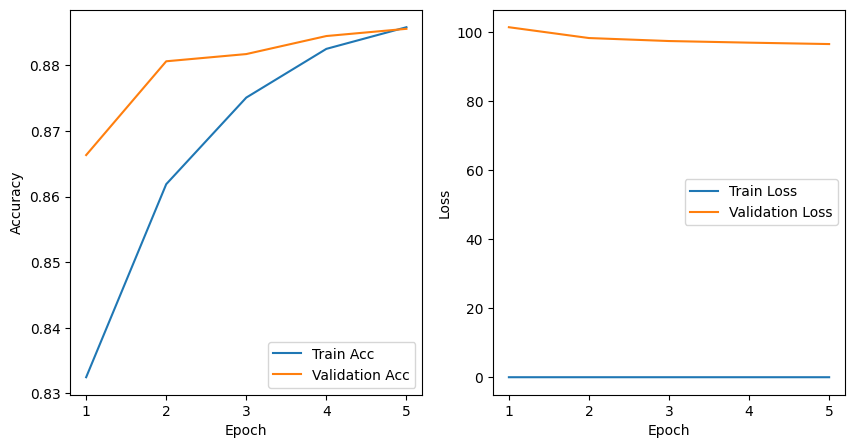

In [36]:
print(history3["train_loss"])
train_loss = [tensor.item() for tensor in history3["train_loss"]]
print(train_loss)

trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history3["train_acc"]),
            ("Validation Acc", history3["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", train_loss),
            ("Validation Loss", history3["valid_loss"])
        ]
    }
)

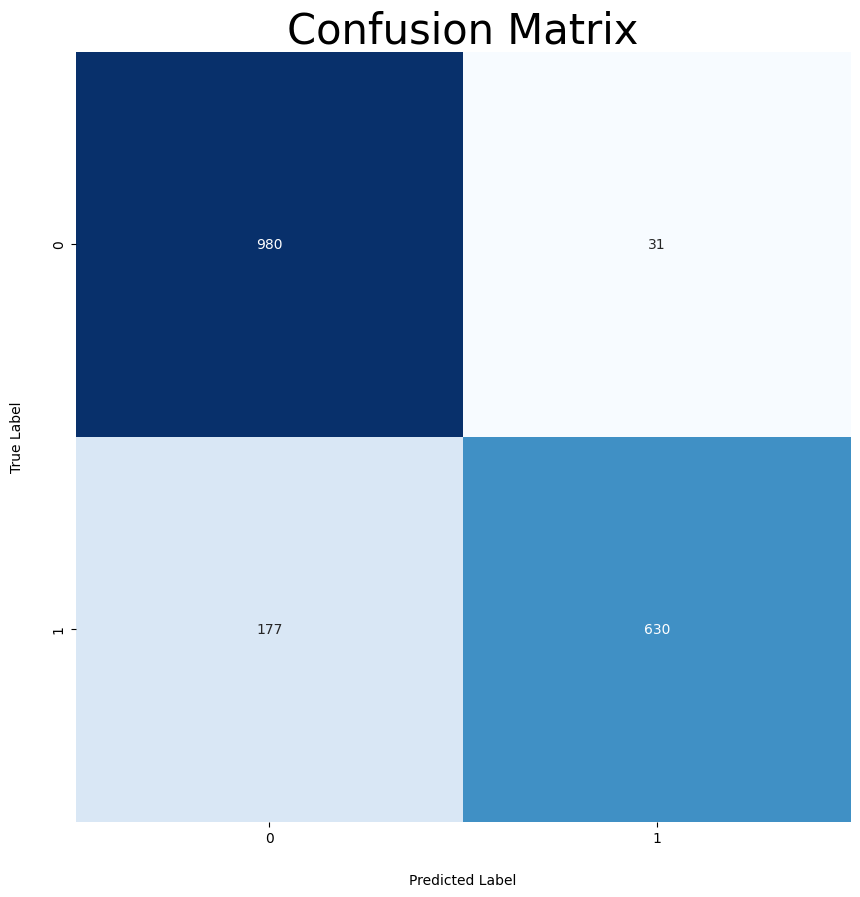

In [37]:
cnn_model_report = generate_confusion_matrix(
    model=model3,
    dataset=test_set,
)

In [38]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.875
F1:        0.881
Precision: 0.900
              precision    recall  f1-score   support

           0       0.85      0.97      0.90      1011
           1       0.95      0.78      0.86       807

    accuracy                           0.89      1818
   macro avg       0.90      0.88      0.88      1818
weighted avg       0.89      0.89      0.88      1818



# Evaluation of model with 32 batch size and 0.00001 lr

In [40]:
# Print classification report for the test set
test_loader = DataLoader(test_set, batch_size=32)
test_loss, test_acc = model_eval(model4, test_loader, loss_function, 'auto')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

model val accuracy 87.35%  Loss: 24.91
Test Loss: 24.910677939653397, Test Accuracy: 0.8734873533248901


[tensor(0.0020, grad_fn=<DivBackward0>), tensor(0.0021, grad_fn=<DivBackward0>), tensor(0.0017, grad_fn=<DivBackward0>), tensor(0.0014, grad_fn=<DivBackward0>), tensor(0.0018, grad_fn=<DivBackward0>)]
[0.0019808276556432247, 0.0020851069130003452, 0.0017128493636846542, 0.0013763851020485163, 0.0017520105466246605]


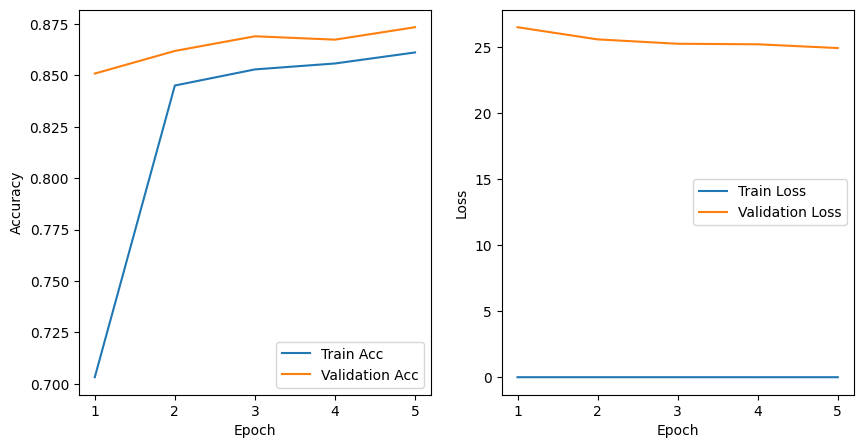

In [41]:
print(history4["train_loss"])
train_loss = [tensor.item() for tensor in history4["train_loss"]]
print(train_loss)

trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history4["train_acc"]),
            ("Validation Acc", history4["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", train_loss),
            ("Validation Loss", history4["valid_loss"])
        ]
    }
)

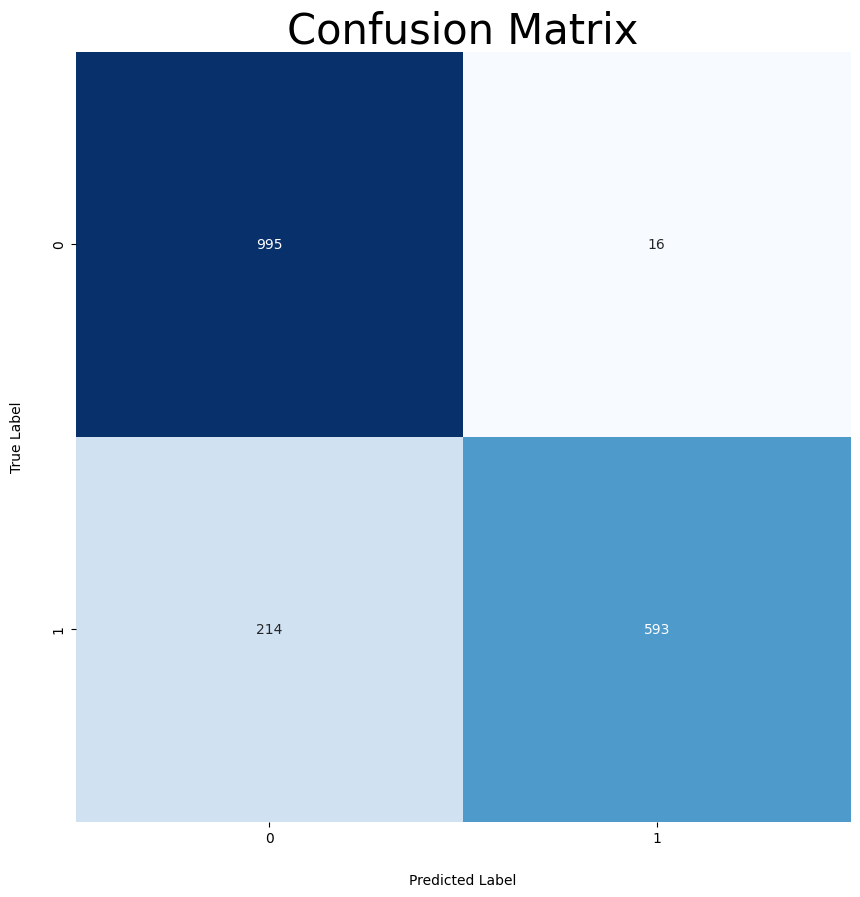

In [42]:
cnn_model_report = generate_confusion_matrix(
    model=model4,
    dataset=test_set,
)

In [43]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.859
F1:        0.867
Precision: 0.898
              precision    recall  f1-score   support

           0       0.82      0.98      0.90      1011
           1       0.97      0.73      0.84       807

    accuracy                           0.87      1818
   macro avg       0.90      0.86      0.87      1818
weighted avg       0.89      0.87      0.87      1818



# Changing the sequence length from 64 to 196 section 3

<font color='red'>1.</font>

Memory Usage: Larger context windows require more memory to store and process the additional information, which can be a significant constraint for long documents or resource-limited environments.

Processing Time: More data to process means longer processing times, which can slow down the training and inference phases of the model.

Improved Disambiguation: Larger context windows allow models to better understand the meaning of ambiguous words by considering more surrounding text.

Contextual Coherence: Understanding the broader context helps in maintaining coherence in tasks like text generation and translation, leading to more accurate and relevant outputs.

<font color='red'>2.</font>

In [51]:
sequence_len = 196

# Initialize the Twitter dataset
dataset2 = Twitter(df, w2v_model, sequence_len)
dataset2.seq_report()

Deleted 0-Len Samples: 31


<ipython-input-14-3c869faa1126>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe[self.df_token_col] = self.dataframe[self.df_token_col].map(self._pad)
<ipython-input-14-3c869faa1126>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.dataframe["vector"] = self.dataframe[self.df_token_col].map(self._get_word_vectors)


Sequence Length Report
:::::MAX  LENGTH:::[ 196 ]
:::::MIN  LENGTH:::[ 196 ]
:::::MEAN LENGTH:::[196.0]
Sequence Tokenization Report
:::::All Unique Tokens:::[19245 
:::::All Valid Tokens:::[12227 
:::::Valid Tokens:::[63.53%]


In [52]:
import numpy as np
from sklearn.model_selection import train_test_split


# Extract features and labels
vectors = [item[0] for item in dataset2]
intentions = [item[1] for item in dataset2]

# Convert lists to numpy arrays
vectors = np.array(vectors)
intentions = np.array(intentions)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vectors, intentions, test_size=0.2, random_state=42)

In [53]:
X_train_reshaped = X_train.transpose(0, 2, 1)  # Permute the dimensions
X_test_reshaped = X_test.transpose(0, 2, 1)  # Permute the dimensions

In [54]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets
train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)


<font color='red'>3.</font>

In [55]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_196(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN_196, self).__init__()
        # print("hey")
        self.layers = nn.Sequential(*[
        nn.Conv1d(in_channels=300, out_channels=196, kernel_size=3),
        nn.Conv1d(in_channels=196, out_channels=64, kernel_size=5),
        nn.Conv1d(in_channels=64, out_channels=196, kernel_size=7),
        nn.Conv1d(in_channels=196, out_channels=128, kernel_size=3),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        ])

        # Apply Glorot initialization to convolutional layers
        for name, module in self.layers.named_modules():
            if isinstance(module, nn.Conv1d):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)



        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(22016, 128)  # Output size after conv1d layer
        self.fc2 = nn.Linear(128, 2)

        # Apply Glorot initialization to fully connected layers
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

        if self.fc1.bias is not None:
            nn.init.zeros_(self.fc1.bias)
        if self.fc2.bias is not None:
            nn.init.zeros_(self.fc2.bias)


    def forward(self, x):

        for layer in self.layers:
          x = layer(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # Softmax for classification
        return x


In [56]:
model2 = CNN_196()
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# Call the train_model function
history2 = train_model(
    model=model2,
    batch_size=8,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=5,
    train_set=train_set,
    valid_set=test_set,
    device='auto'  # Automatically select 'cuda' if available, otherwise 'cpu'
)


Epoch 0: model train accuracy 80.54% Loss: 0.00


model val accuracy 80.69%  Loss: 115.30
Epoch 1: model train accuracy 80.66% Loss: 0.00


model val accuracy 80.69%  Loss: 115.30
Epoch 2: model train accuracy 80.66% Loss: 0.00


model val accuracy 80.69%  Loss: 115.30
Epoch 3: model train accuracy 80.66% Loss: 0.00


model val accuracy 80.69%  Loss: 115.30
Epoch 4: model train accuracy 80.66% Loss: 0.00


model val accuracy 80.69%  Loss: 115.30


In [57]:
# Print classification report for the test set
test_loader = DataLoader(test_set, batch_size=8)
test_loss, test_acc = model_eval(model2, test_loader, loss_function, 'auto')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

model val accuracy 80.69%  Loss: 115.30
Test Loss: 115.2986578643322, Test Accuracy: 0.8069307208061218


In [58]:
train_acc = [tensor.item() for tensor in history2["train_acc"]]
valid_acc = [tensor.item() for tensor in history2["valid_acc"]]
train_loss = [tensor.item() for tensor in history2["train_loss"]]
valid_loss = history2["valid_loss"]


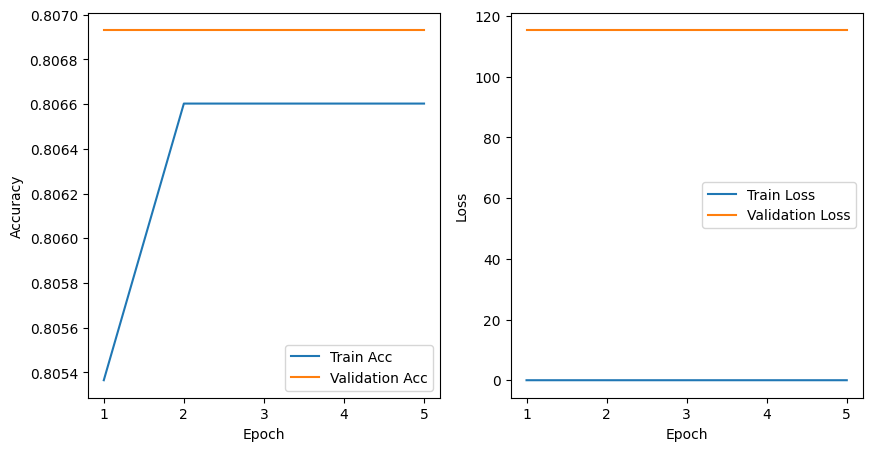

In [60]:
trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", train_acc),
            ("Validation Acc", valid_acc),
        ],
        "Loss - Epoch": [
            ("Train Loss", train_loss),
            ("Validation Loss", valid_loss)
        ]
    }
)

<font color='red'>4.</font>

first the batch size is reduced to 8 beacuse of ram crash and also the structure of the cnn is modified based on the new sequence_length.
The results are typically better than the time when the sequence length was 64. It is beacuse more text is passed to the model and model can understand the time relation better in comparison to the 64 max token size.

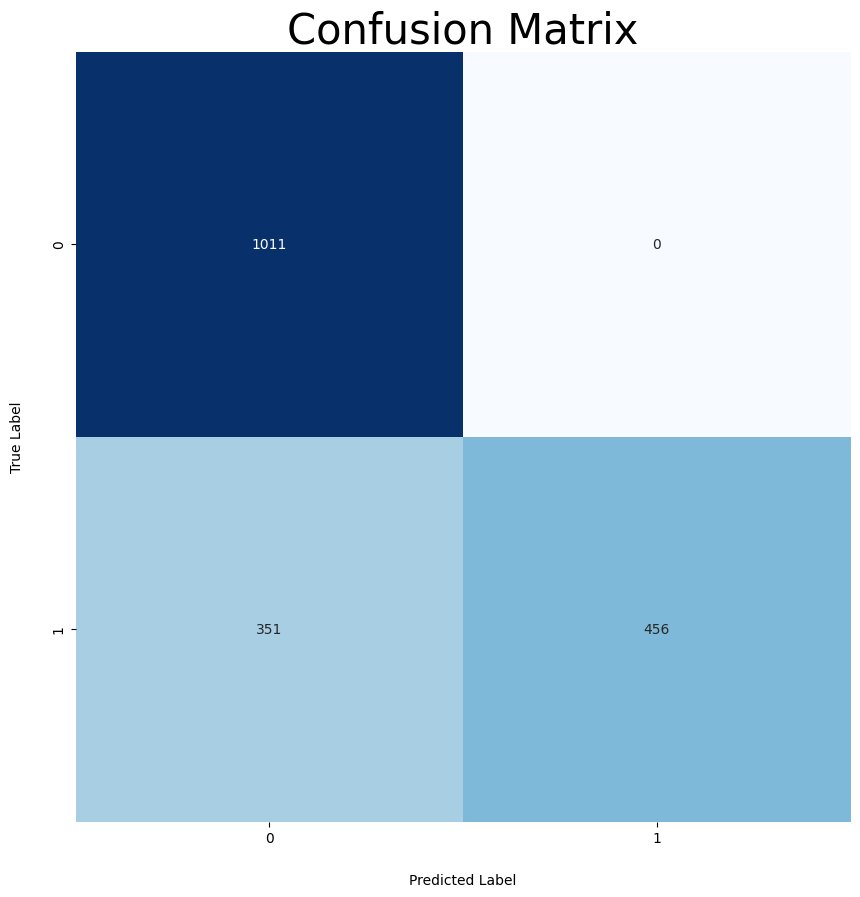

In [61]:
cnn_model_report = generate_confusion_matrix(
    model=model2,
    dataset=test_set,
)

In [62]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.783
F1:        0.787
Precision: 0.871
              precision    recall  f1-score   support

           0       0.74      1.00      0.85      1011
           1       1.00      0.57      0.72       807

    accuracy                           0.81      1818
   macro avg       0.87      0.78      0.79      1818
weighted avg       0.86      0.81      0.79      1818



it was computationally expensive and it took more time for training

# Regulization techniques section 4 (with 64 as context window, 32 batch size and 0.00001 lr)

dataset is the data with context window of 64, dataset2 is the data with context window of 196

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Assuming `dataset` is a list of (vector, intention) tuples
# Example: dataset = [(np.array([0.1, 0.2, 0.3]), 'intention1'), (np.array([0.4, 0.5, 0.6]), 'intention2'), ...]

# Extract features and labels
vectors = [item[0] for item in dataset]
intentions = [item[1] for item in dataset]

# Convert lists to numpy arrays
vectors = np.array(vectors)
intentions = np.array(intentions)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(vectors, intentions, test_size=0.2, random_state=42)


In [ ]:
X_train_reshaped = X_train.transpose(0, 2, 1)  # Permute the dimensions
X_test_reshaped = X_test.transpose(0, 2, 1)  # Permute the dimensions
print(X_train_reshaped.shape)


(7270, 300, 64)


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_reshaped, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_reshaped, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create PyTorch datasets
train_set = TensorDataset(X_train_tensor, y_train_tensor)
test_set = TensorDataset(X_test_tensor, y_test_tensor)




In [45]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Reg(nn.Module):
    def __init__(self): # TODO: define your args here
        super(CNN_Reg, self).__init__()
        # print("hey")
        self.layers = nn.Sequential(*[
        nn.Conv1d(in_channels=300, out_channels=64, kernel_size=3),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5),
        nn.Conv1d(in_channels=64, out_channels=64, kernel_size=7),
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5),
        nn.Conv1d(in_channels=128, out_channels=128, kernel_size=7)
        ])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5120, 128)  # Output size after conv1d layer
        self.fc_bn1 = nn.BatchNorm1d(128)  # Batch Norm after first dense layer
        self.dropout = nn.Dropout(p=0.1)
        self.fc2 = nn.Linear(128, 2)
    def forward(self, x):

        for layer in self.layers:
          x = layer(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc_bn1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # Softmax for classification
        return x



In [46]:
model5 = CNN_Reg()
# Define the loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model5.parameters(), lr=0.00001)

# Call the train_model function
history5 = train_model(
    model=model5,
    batch_size=32,
    loss_function=loss_function,
    optimizer=optimizer,
    epochs=5,
    train_set=train_set,
    valid_set=test_set,
    device='auto'  # Automatically select 'cuda' if available, otherwise 'cpu'
)


Epoch 0: model train accuracy 83.48% Loss: 0.00


model val accuracy 86.47%  Loss: 25.66
Epoch 1: model train accuracy 85.49% Loss: 0.00


model val accuracy 86.80%  Loss: 25.77
Epoch 2: model train accuracy 86.20% Loss: 0.00


model val accuracy 88.23%  Loss: 24.75
Epoch 3: model train accuracy 87.26% Loss: 0.00


model val accuracy 87.79%  Loss: 24.96
Epoch 4: model train accuracy 87.50% Loss: 0.00


model val accuracy 88.28%  Loss: 24.61


# Evaluation of regulized model

In [47]:
# Print classification report for the test set
test_loader = DataLoader(test_set, batch_size=32)
test_loss, test_acc = model_eval(model5, test_loader, loss_function, 'auto')
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

model val accuracy 88.28%  Loss: 24.61
Test Loss: 24.605307906866074, Test Accuracy: 0.8828383088111877


[tensor(0.0017, grad_fn=<DivBackward0>), tensor(0.0021, grad_fn=<DivBackward0>), tensor(0.0023, grad_fn=<DivBackward0>), tensor(0.0024, grad_fn=<DivBackward0>), tensor(0.0021, grad_fn=<DivBackward0>)]
[0.0017019002698361874, 0.0020613258238881826, 0.002280849264934659, 0.0023605928290635347, 0.0021069017238914967]


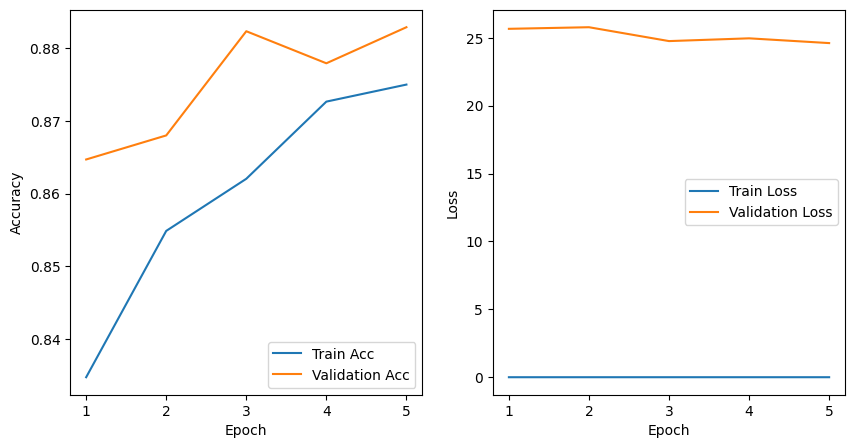

In [48]:
print(history5["train_loss"])
train_loss = [tensor.item() for tensor in history5["train_loss"]]
print(train_loss)

trend_plot_helper(
    {
        "Accuracy - Epoch": [
            ("Train Acc", history5["train_acc"]),
            ("Validation Acc", history5["valid_acc"]),
        ],
        "Loss - Epoch": [
            ("Train Loss", train_loss),
            ("Validation Loss", history5["valid_loss"])
        ]
    }
)

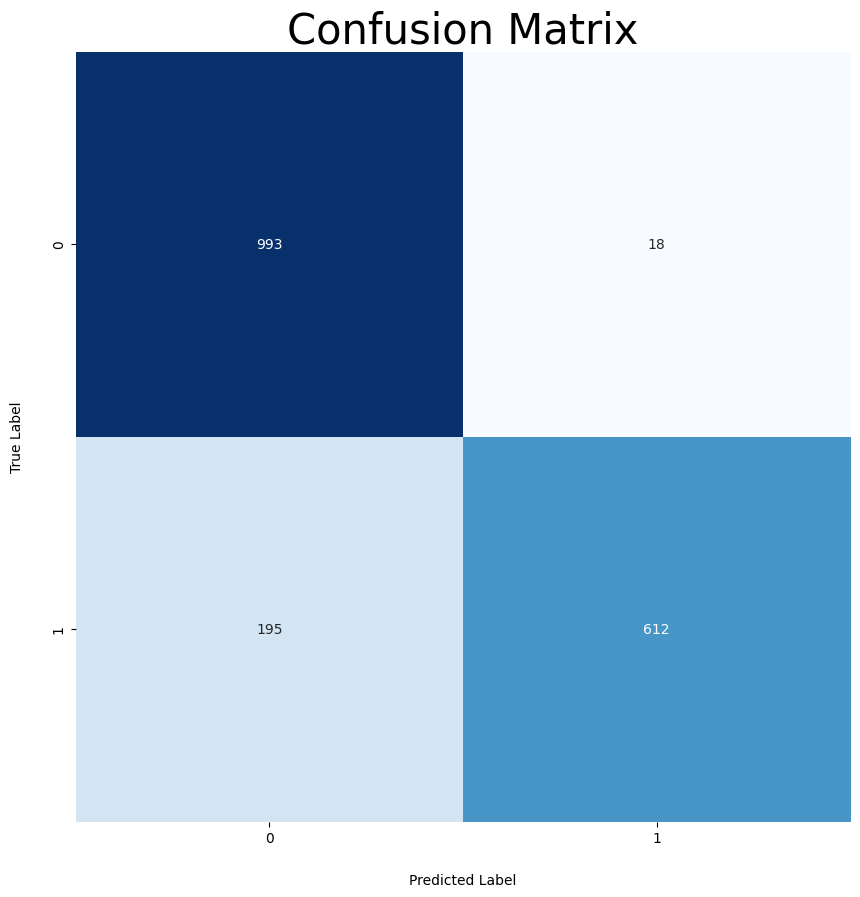

In [49]:
cnn_model_report = generate_confusion_matrix(
    model=model5,
    dataset=test_set,
)

In [50]:
print(f"Recall:    {cnn_model_report['recall']:.3f}")
print(f"F1:        {cnn_model_report['f1']:.3f}")
print(f"Precision: {cnn_model_report['precision']:.3f}")
print(cnn_model_report['report'])

Recall:    0.870
F1:        0.877
Precision: 0.904
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1011
           1       0.97      0.76      0.85       807

    accuracy                           0.88      1818
   macro avg       0.90      0.87      0.88      1818
weighted avg       0.90      0.88      0.88      1818



Regulized model performs a bit better (1 percent difference) from the model with no BN and dropout layers